# Room Acoustic Measurment

## Background

This is a prototype program that will be able to run testing on your room accoustic. All you need to do is perform a few recordings, those being the following:
1. Recording of an impulse response (WAV of IR is provided below)
2. Recording of a sine sweep (WAV of sweep also provided)

These recordings must be done in a 24-bit, 44.1kHZ, .wav format (Single channel is fine atm). Positionally the microphone should be in the position you listen from at ear position height. To perform test recordings must have minimal background noise. Run your wave files through the "floorNoiseCheck" function before performing any other tasks. This will give you a boolean and a leaking background noise measurment result.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import librosa.display as ld
import scipy.signal as sc
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

In [3]:
def curveFit(x,m,b):
    return m*x+b

In [2]:
def reverbTimeCalc(signal, window_size, N):
    
    x_anyl = abs(sc.hilbert(signal))/np.max(abs(signal)) #Analytical signal removes any phase information
    x_log = 20.0*np.log10(x_anyl) #Take the log to get the power singal

    ma_filter = np.ones(window_size) / window_size
    x_ma = np.convolve(x_anyl, ma_filter, mode='same') #Filter the signal to remove noise

    x_ma1 = x_ma[:N]

    sch = 10.0 * np.log10(np.cumsum(x_ma1[::-1]**2)[::-1] / np.max(np.cumsum(x_ma1[::-1]**2))) #Integrate using Schroders integral
    
    ##ANALYSIS
    popt,pconv = curve_fit(func,t[:N],sch)
    m,b = popt
    y = m * t + b
    
    reverbTimeArr = [-60/m,-30/m,-20/m,-10/m]
    
    return reverbTimeArr

In [ ]:
def freqResponse(signal, ):
    sigFFT = np.fft.rfft(signal)
    pwrSpec = 10*np.log10(sigFFT)
    
    
    
    
    

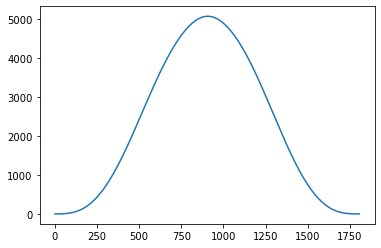

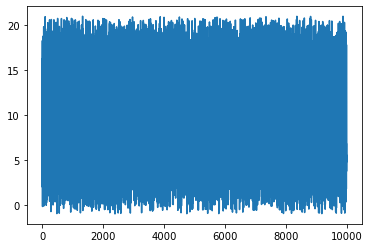

In [9]:
def snrAnyl(signal, fs,  frame_length,  overlap, window_type):
    """
    SNR Analyzer. Will determine the snr levels of your room, ie: ratio between floor noise and direct signal
    
    signal: time-series audio vector
    fs: sampling rate 
    frame_length: number of samples to be processed per frame
    window_type: boxcar, triangle, hann, hamming, etc. 
    overlap: amount of overlapped windows

    """
    if (overlap == 0):
        step = 1;
        numWindows = np.ceil(len(signal)/frame_length);
    else:
        step = int(np.round(overlap*frame_length));
        numWindows = np.ceil(len(signal)/(overlap*frame_length));
    # print(step)
    # print("start_ix : end_ix")
    # print("----------------")
    for i in range(0,len(signal),step):
        st = i
        en = min(frame_length + i, len(signal))
        
        #If end index - start index is less thatn window length - step break
        if (en - st < frame_length - step):
            break
        
        window = sc.windows.get_window(window_type, frame_length);
        #Window/Filter signal 
        winDodSig = sc.convolve(signal[st:en],window)
        


  

        
    plt.figure(1)
    plt.plot(signal)      
        
#         sigFFT = np.fft.rfft(signal)
#         freq = np.fft.rfftfreq(len(signal), 1/fs)
#         #Remove DC component
#         sigFFT[0] = 0
    
    
    # plt.plot(freq,np.abs(sigFFT))
    # return sigFFT


fs = 10000;
t = np.arange(0,1,1/fs)
signal = np.sin(2*np.pi*4000*t)
noiz = 20*np.random.rand(len(t))


snrAnyl(signal+noiz,fs, 1024, 0.5, "hann")

#print(len(signal))


In [1]:
#git test